In [1]:
#Python library
import pandas as pd
import numpy as np
from numpy import mean, std
import pickle

#import visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns  
import plotly


#import sklearn library 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score


#import keras library
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


In [2]:
class Forklift:
    
    def read_data(slef,data_path,sep=","):
        """
         Function to read data and return dataframe.
        :param data_path: path to read the file.
        :param sep: define separator to read file.
        :return: dataframe.

        """
        #read csv
        data=pd.read_csv(data_path,sep=sep)
        print("shape of data: {} \n".format(data.shape))
        print("columns in data: {} \n".format(data.columns))
        print("show null values in data: ")
        print(data.isnull().sum())
        print("data types for the records \n")
        print(data.dtypes)
        return data


    def process_data(slef,predictor,df,label):
        """
         Function to process data and return test and train sets.
        :param predictor: type of predictor regressor or classifier.
        :param df: dataframe.
        :param label: true label for the model.
        :return: test and train sets.

        """

        if predictor=="regressor":
            #scaler
            scaler=StandardScaler()
            #choose true labels or classes
            y=df[label]
            #create features
            data=df.copy()
            X=data.drop([label],axis=1)
            X_scaled=scaler.fit_transform(X)

            #split data into train and test sets.
            X_train, X_test, y_train, y_test=\
                                train_test_split(X_scaled, y, test_size = 0.25)

            print('train data features and labels shape:  {} {} '.format(X_train.shape,y_train.shape))
            print('test data features and labels shape:   {} {}'.format(X_test.shape,y_test.shape))#
            return X_train, X_test, y_train, y_test

        else:

            #choose true labels or classes
            y=df[label]
            #create features
            data=df.copy()
            X=data.drop([label],axis=1)
            #split data into train and test sets.
            X_train, X_test, y_train, y_test=\
                                train_test_split(X, y, test_size = 0.25, random_state = 21, stratify=y)
            return X_train, X_test, y_train, y_test
        
        
    def label_distribution(self,data, features, plot_title):

        """
         Function to plot the class label distributions.
        :param data: dataframe of interest.
        :param features: feature for distribution.
        :param plot_title: title of the plot.
        :return: plot the class label distributions.

        """

        #show the class labels distributions in the dataset.
        class_labels_df = data[features].value_counts().reset_index()
        class_labels_df.columns = [
            'label', 
            'percent'
        ]

        class_labels_df['percent'] /= len(data)

        fig = px.pie(
            class_labels_df, 
            names='label', 
            values='percent', 
            title=plot_title, 
            width=800,
            height=500,

        )

        plotly.offline.plot(fig,filename='./output/'+plot_title+'.html',auto_open=False)
        fig.show()


    def feature_correlation_plot(self,df,title):
        """
         Function to plot feature correlation.
        :param df: dataframe of interest.
        :param title: title of the plot.
        :return: plot feature correlation.
        """

        # heatmap for feature correlation
        plt.figure(figsize = (10,10))
        ax=sns.heatmap(df.corr(),cmap='coolwarm', linewidths=0.5, annot=True)
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)

        plt.title(title)
        plt.tight_layout()
        plt.savefig('./output/'+title)
        #plt.show()



    # evaluate a model
    def evaluate_model(self,X_train,y_train,model,X_test,y_test,predictor,model_name):
        """
        This function will train the model and return the model efficiency on test data.
        :param X_train,y_train,model,X_test,y_test:  Train/test features and labels.
        :return: model evaluation in the form classification report or r2_score.

        """
        if predictor=="classifier":
            model.fit(X_train, y_train)
            # Predicting the Test set results
            y_pred = model.predict(X_test)

            # define evaluation procedure
            print(classification_report(y_test, y_pred))

            # save the classifier
            with open('./trained_model/'+model_name+'.pkl', 'wb') as f:
                pickle.dump(model, f)  

            return classification_report(y_test, y_pred)

        #create the model
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)

        # save the classifier
        with open('./trained_model/'+model_name+'.pkl', 'wb') as f:
            pickle.dump(model, f)  

        #metrics to check the regression model on test data.
        score=r2_score(y_test, y_pred)
        #print("regressor r2_score: {}".format(r2_score(y_test, y_pred)))

        return score




    def baseline_model(self,X_train,y_train,X_test,y_test):
        """"
        This function defines the Neural Network architecture and output the trained model.
        """
        model = Sequential()
        model.add(Dense(12, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.summary()
        #compile model
        model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
        #early stop the model when there is no change in loss.
        early_stop = EarlyStopping(monitor = 'loss', min_delta = 0.001, 
                                   patience = 4, mode = 'min', verbose = 1,
                                   restore_best_weights = True)

        # fit model
        history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2,callbacks = [early_stop])

        print(history.history.keys())
        # "Loss"
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        return model

In [3]:
#create class object
forklift= Forklift()

# core data Visualisation, Preprocessing & Modeling.

In [7]:
#read csv data
core_data=forklift.read_data("./datasets/1_flottenuebersicht_land.csv")
core_data.head()

shape of data: (848, 24) 

columns in data: Index(['warenempfaenger', 'land', 'warenempfaenger_nummer', 'strasse', 'plz',
       'ort', 'interne_nummer', 'equipment_nummer', 'segment', 'typ',
       'hersteller', 'baujahr', 'alter', 'vertrag', 'mietkategorie',
       'servicevertrag', 'vereinbarte_betriebsstunden', 'zugangsmodul',
       'empfangen', 'letzter_datenempfang', 'kostenstelle', 'einsatzort',
       'fuehrerscheinklasse', 'freies_merkmal'],
      dtype='object') 

show null values in data: 
warenempfaenger                  0
land                           848
warenempfaenger_nummer           0
strasse                          0
plz                              0
ort                            848
interne_nummer                 131
equipment_nummer                 0
segment                          0
typ                              0
hersteller                       0
baujahr                          0
alter                            0
vertrag                          0
mie

warenempfaenger  land  warenempfaenger_nummer strasse  plz  ort  \
0             ABC   NaN                       1   Weg 1  123  NaN   
1             ABC   NaN                       1   Weg 1  123  NaN   
2             ABC   NaN                       1   Weg 1  123  NaN   
3             ABC   NaN                       1   Weg 1  123  NaN   
4             ABC   NaN                       1   Weg 1  123  NaN   

   interne_nummer  equipment_nummer                        segment      typ  \
0             1.0                 1  Elektro. Gegengewichtsstapler  EFG 216   
1             2.0                 2  Elektro. Gegengewichtsstapler  EFG 216   
2             3.0                 3  Elektro. Gegengewichtsstapler  EFG 216   
3             4.0                 4  Elektro. Gegengewichtsstapler  EFG 216   
4             5.0                 5  Elektro. Gegengewichtsstapler  EFG 216   

     hersteller  baujahr alter                  vertrag  mietkategorie  \
0  Jungheinrich     2012   8,2  Rental Fleet Management  RFM CoreFleet   
1  Jungheinrich     2013     7  Rental Fleet Management  RFM CoreFleet   
2  Jungheinrich     2014   6,5  Rental Fleet Management  RFM CoreFleet   
3  Jungheinrich     2014   6,5  Rental Fleet Management  RFM CoreFleet   
4  Jungheinrich     2014   6,5  Rental Fleet Management  RFM CoreFleet   

  servicevertrag  vereinbarte_betriebsstunden zugangsmodul empfangen  \
0   Full Service                         1200            X        Ja   
1   Full Service                         1200            X        Ja   
2   Full Service                         1200            X        Ja   
3   Full Service                         1200            X        Ja   
4   Full Service                         1200            X        Ja   

  letzter_datenempfang  kostenstelle  einsatzort  fuehrerscheinklasse  \
0  2020-09-09 06:28:27           NaN         NaN                    0   
1  2020-09-09 06:02:13           NaN         NaN                    0   
2  2020-09-09 03:58:05           NaN         NaN                    0   
3  2020-09-09 07:04:57           NaN         NaN                    0   
4  2020-09-09 05:43:47           NaN         NaN                    0   

   freies_merkmal  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

features distribution

In [8]:
#plot future distribution
forklift.label_distribution(core_data, 'segment',' core_data segment distribution')
forklift.label_distribution(core_data, 'mietkategorie','core_data mietkategorie distribution')
forklift.label_distribution(core_data, 'hersteller','core_data hersteller distribution')
forklift.label_distribution(core_data, 'vertrag','core_data vertrag distribution')
forklift.label_distribution(core_data, 'servicevertrag','core_data servicevertrag distribution')#servicevertrag      
forklift.label_distribution(core_data, 'fuehrerscheinklasse','core_data fuehrerscheinklasse distribution')

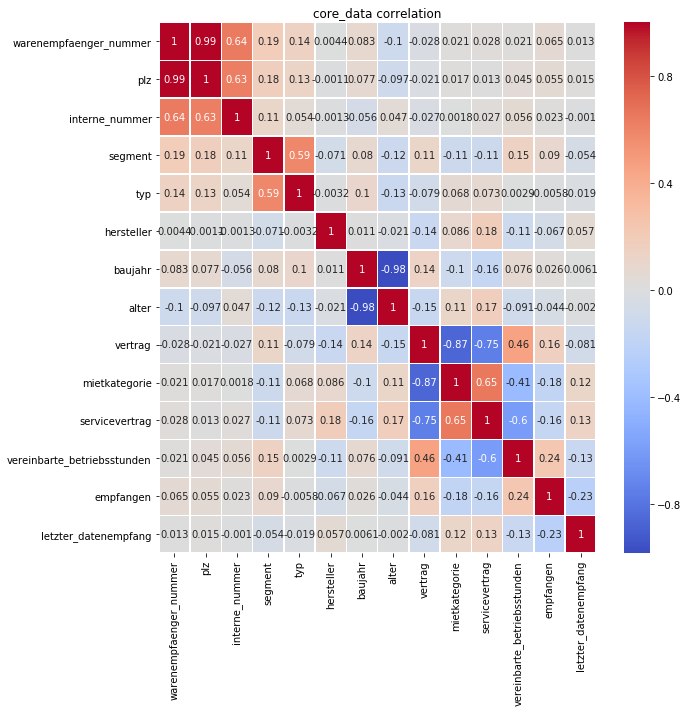

In [23]:
#plot correlation
forklift.feature_correlation_plot(core_data,'core_data correlation')

Feature Engineering

In [9]:
# data preprocessing
#drop columsn with null values or columns which does make sense for example fuehrerscheinklasse, which has only label as 0
core_data.drop(['warenempfaenger','land','ort','zugangsmodul','kostenstelle','einsatzort','freies_merkmal',
                'fuehrerscheinklasse','equipment_nummer','strasse'],axis=1,inplace=True)

#change lable of empfangen column to 1 for "ja" else 0
core_data['empfangen']=core_data['empfangen'].apply(lambda x: 1 if x =='Ja' else 0)

#encode the categorical values using Sklearn Labelcencoder package.
core_data[['segment','typ','hersteller','vertrag','mietkategorie','servicevertrag','letzter_datenempfang']]= \
core_data[['segment','typ','hersteller','vertrag','mietkategorie','servicevertrag','letzter_datenempfang']].apply(LabelEncoder().fit_transform)
core_data['alter']=core_data['alter'].apply(lambda x: x.replace(',', '.')).astype(float).astype(int)

#fill nulll values with 0
core_data.fillna(0,inplace=True)
core_data.head()

warenempfaenger_nummer  plz  interne_nummer  segment  typ  hersteller  \
0                       1  123             1.0        0    7           0   
1                       1  123             2.0        0    7           0   
2                       1  123             3.0        0    7           0   
3                       1  123             4.0        0    7           0   
4                       1  123             5.0        0    7           0   

   baujahr  alter  vertrag  mietkategorie  servicevertrag  \
0     2012      8        2              2               0   
1     2013      7        2              2               0   
2     2014      6        2              2               0   
3     2014      6        2              2               0   
4     2014      6        2              2               0   

   vereinbarte_betriebsstunden  empfangen  letzter_datenempfang  
0                         1200          1                   454  
1                         1200          1                   346  
2                         1200          1                   243  
3                         1200          1                   649  
4                         1200          1                   311

Core data of the fleet : we can use this data to predict the type of Forklifts i.e segments.
        
        The problem will be classified as multiclass classification problem.
        There are 9 types of segments in total in the given dataset.
        We can use Random Forest algorithm to build our predictor.
        To validate our model, we have split data into train and test using Sklearn train_test_split.
        Since there are 9 different classes, so we have used stratify split to have same ratio of class in test & test.
        We have used class_weight as "balanced_subsample" in RF model to counter the class imbalancement.
        To validate our model we have used Sklearn classification_report, which gives per class classification.
        
Rseults:

        From classification report, we can observe that model works very well for those classes which has more records.
        However, model also able to pick minority classes. 
        Given the small amount of data, our model able to handle both majority and minority classes very well.
        
Imporvements:

        We can cross validation to hypter tune the parameters.
        To counter class imbalancement we can use synthetic over sampler such as SMOTE.
        We can also combine minority classes with very less records and do the classification.
        We can create one vs rest model and with that we can create ensembles.

In [10]:
#compute train & test sets.
X_train, X_test, y_train, y_test = forklift.process_data("classifier",core_data,'segment')
#create the model
model = RandomForestClassifier(n_estimators=500, max_depth=3,class_weight="balanced_subsample",random_state=15)
#train and evaluate the model
score = forklift.evaluate_model(X_train,y_train,model,X_test,y_test,'classifier','core_data_segment')

              precision    recall  f1-score   support

           0       0.82      0.97      0.89        38
           1       0.67      1.00      0.80         2
           2       0.44      0.92      0.59        12
           3       0.89      0.44      0.59        18
           4       0.50      1.00      0.67         3
           5       0.88      0.71      0.78        69
           6       1.00      1.00      1.00        24
           7       0.00      0.00      0.00         1
           8       1.00      0.98      0.99        45

    accuracy                           0.84       212
   macro avg       0.69      0.78      0.70       212
weighted avg       0.87      0.84      0.84       212



C:\Users\49176\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\49176\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\49176\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\49176\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

# Cost_Per_Vehicle data Visualisation, Preprocessing & Modeling.

In [12]:
#read csv data
cost_per_vehicle= forklift.read_data("./datasets/2_kosten_gestapelt_land.csv",sep=";")
cost_per_vehicle.head()

shape of data: (1138, 43) 

columns in data: Index(['warenempfaenger', 'warenempfaenger_nummer', 'land', 'strasse',
       'postleitzahl', 'ort', 'interne_nummer', 'equipment_nummer', 'segment',
       'typ', 'hersteller', 'baujahr', 'alter', 'verkaufsvertrag',
       'mietkategorie', 'vereinbarte_betriebsstunden', 'zugangsmodul',
       'kostenstelle', 'einsatzort', 'fuehrerscheinklasse', 'freies_merkmal',
       'gesamtkosten', 'finanzierungskosten', 'mietkosten', 'servicekosten',
       'servicekosten_A_lohn', 'servicekosten_A_ersatzteile',
       'servicekosten_A_pauschalen', 'servicekosten_B_gewaltschaden',
       'servicekosten_B_kostenpflichtige_leistungen',
       'servicekosten_B_restriktionen', 'servicekosten_B_full_service',
       'servicekosten_B_sonstige', 'servicekosten_C_reparatur',
       'servicekosten_C_wartung', 'servicekosten_C_lservice',
       'servicekosten_C_sicherheitspruefung', 'servicekosten_C_full_service',
       'servicekosten_D_wartung_sicherheit', 'serv

warenempfaenger  warenempfaenger_nummer  land strasse  postleitzahl  ort  \
0             ABC                       7   NaN   Weg 7           456  NaN   
1             ABC                       7   NaN   Weg 7           456  NaN   
2             ABC                       7   NaN   Weg 7           456  NaN   
3             ABC                       7   NaN   Weg 7           456  NaN   
4             ABC                       7   NaN   Weg 7           456  NaN   

   interne_nummer  equipment_nummer             segment      typ  \
0           183.0               240    Hochregalstapler  EKX 515   
1           184.0               241    Hochregalstapler  EKX 515   
2           181.0               238  Niederhubwagen-KMS  ECE 220   
3           627.0               849      Niederhubwagen  ERE 225   
4           239.0               296  Niederhubwagen-KMS  ECE 225   

     hersteller  baujahr  alter          verkaufsvertrag  mietkategorie  \
0  Jungheinrich     2007   13.0                    Miete            NaN   
1  Jungheinrich     2007   13.0                    Miete            NaN   
2  Jungheinrich     2004   16.0   Kundeneigenes Fahrzeug            NaN   
3  Jungheinrich     2015    4.9  Rental Fleet Management  RFM CoreFleet   
4  Jungheinrich     2016    4.7  Rental Fleet Management  RFM CoreFleet   

   vereinbarte_betriebsstunden zugangsmodul  kostenstelle  einsatzort  \
0                          0.0            X           NaN         NaN   
1                          0.0            X           NaN         NaN   
2                          0.0          NaN           NaN         NaN   
3                        900.0            X           NaN         NaN   
4                        900.0            X           NaN         NaN   

   fuehrerscheinklasse  freies_merkmal  gesamtkosten  finanzierungskosten  \
0                    0             NaN           0.0                    0   
1                    0             NaN           0.0                    0   
2                    0             NaN           0.0                    0   
3                    0             NaN           0.0                    0   
4                    0             NaN           0.0                    0   

   mietkosten  servicekosten  servicekosten_A_lohn  \
0         0.0            0.0                   0.0   
1         0.0            0.0                   0.0   
2         0.0            0.0                   0.0   
3         0.0            0.0                   0.0   
4         0.0            0.0                   0.0   

   servicekosten_A_ersatzteile  servicekosten_A_pauschalen  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   

   servicekosten_B_gewaltschaden  servicekosten_B_kostenpflichtige_leistungen  \
0                            0.0                                          0.0   
1                            0.0                                          0.0   
2                            0.0                                          0.0   
3                            0.0                                          0.0   
4                            0.0                                          0.0   

   servicekosten_B_restriktionen  servicekosten_B_full_service  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   servicekosten_B_sonstige  servicekosten_C_reparatur  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2              

Insights from Cost_Per_Vehicle data

In [26]:
forklift.label_distribution(cost_per_vehicle, 'segment',' cost_per_vehicle segment distribution')
forklift.label_distribution(cost_per_vehicle, 'mietkategorie','cost_per_vehicle mietkategorie distribution')
forklift.label_distribution(cost_per_vehicle, 'hersteller',' cost_per_vehicle hersteller distribution')
forklift.label_distribution(cost_per_vehicle, 'baujahr','cost_per_vehicle baujahr distribution')
forklift.label_distribution(cost_per_vehicle, 'verkaufsvertrag','cost_per_vehicle verkaufsvertrag distribution')#servicevertrag      
forklift.label_distribution(cost_per_vehicle, 'postleitzahl','cost_per_vehicle postleitzahl distribution')
forklift.label_distribution(cost_per_vehicle, 'strasse','cost_per_vehicle strasse distribution')

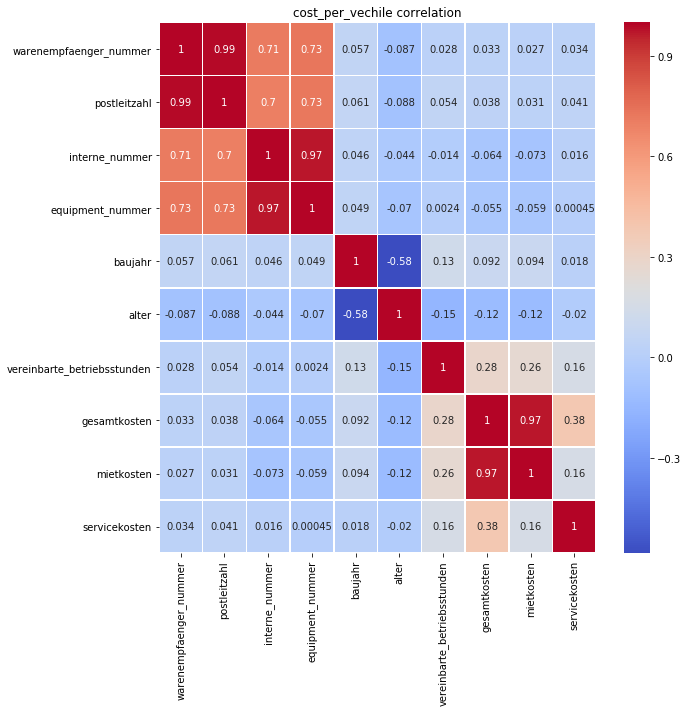

In [28]:
forklift.feature_correlation_plot(cost_per_vehicle[['warenempfaenger_nummer', 'postleitzahl', 'interne_nummer',
       'equipment_nummer', 'segment', 'typ', 'hersteller', 'baujahr', 'alter',
       'verkaufsvertrag', 'mietkategorie', 'vereinbarte_betriebsstunden',
       'gesamtkosten', 'mietkosten', 'servicekosten']] ,'cost_per_vechile correlation')

Feature Engineering

In [13]:
#drop column with null or junk values
cost_per_vehicle.drop(['warenempfaenger','land','ort','zugangsmodul','kostenstelle','einsatzort','freies_merkmal',\
                                'fuehrerscheinklasse','finanzierungskosten','strasse'],axis=1,inplace=True)

#encode the categorical values using Sklearn Labelcencoder package.
cost_per_vehicle[['segment','typ','hersteller','mietkategorie','verkaufsvertrag']]= \
cost_per_vehicle[['segment','typ','hersteller','mietkategorie','verkaufsvertrag']].apply(LabelEncoder().fit_transform)

#fill nulll values with 0
cost_per_vehicle.fillna(0,inplace=True)

cost_per_vehicle.head()

warenempfaenger_nummer  postleitzahl  interne_nummer  equipment_nummer  \
0                       7           456           183.0               240   
1                       7           456           184.0               241   
2                       7           456           181.0               238   
3                       7           456           627.0               849   
4                       7           456           239.0               296   

   segment  typ  hersteller  baujahr  alter  verkaufsvertrag  mietkategorie  \
0        4   41           0     2007   13.0                2              7   
1        4   41           0     2007   13.0                2              7   
2        6    1           0     2004   16.0                1              7   
3        5   48           0     2015    4.9                3              2   
4        6    3           0     2016    4.7                3              2   

   vereinbarte_betriebsstunden  gesamtkosten  mietkosten  servicekosten  \
0                          0.0           0.0         0.0            0.0   
1                          0.0           0.0         0.0            0.0   
2                          0.0           0.0         0.0            0.0   
3                        900.0           0.0         0.0            0.0   
4                        900.0           0.0         0.0            0.0   

   servicekosten_A_lohn  servicekosten_A_ersatzteile  \
0                   0.0                          0.0   
1                   0.0                          0.0   
2                   0.0                          0.0   
3                   0.0                          0.0   
4                   0.0                          0.0   

   servicekosten_A_pauschalen  servicekosten_B_gewaltschaden  \
0                         0.0                            0.0   
1                         0.0                            0.0   
2                         0.0                            0.0   
3                         0.0                            0.0   
4                         0.0                            0.0   

   servicekosten_B_kostenpflichtige_leistungen  servicekosten_B_restriktionen  \
0                                          0.0                              0   
1                                          0.0                              0   
2                                          0.0                              0   
3                                          0.0                              0   
4                                          0.0                              0   

   servicekosten_B_full_service  servicekosten_B_sonstige  \
0                             0                       0.0   
1                             0                       0.0   
2                             0                       0.0   
3                             0                       0.0   
4                             0                       0.0   

   servicekosten_C_reparatur  servicekosten_C_wartung  \
0                        0.0                      0.0   
1                        0.0                      0.0   
2                        0.0                      0.0   
3                        0.0                      0.0   
4                        0.0                      0.0   

   servicekosten_C_lservice  servicekosten_C_sicherheitspruefung  \
0                         0                                  0.0   
1                         0                                  0.0   
2                         0                                  0.0   
3                         0                                  0.0   
4                         0                                  0.0   

   servicekosten_C_full_service  servicekosten_D_wartung_sicherheit  \
0                             0                                 0.0   
1                             0                                 0.0   
2                             0                                 0.0   
3 

cost_per_vehicle: using this data we can predict gesamtkosten.

        The problem will be classified as regression problem as label to predict is continous in nature.
        Since the data is not so large to use Neural Network, we can use Random Forest Regressor as our predictor.
        To validate our model, we have split data into train and test using Sklearn train_test_split.
         To validate our model we have use SKlearn metrics r2_Score i.e R^2 (coefficient of determination) 
         regression score function.
        
Rseults:

        Since our R^2 (coefficient of determination) value is 0.98, we can conclude that our predictor is fitted well.
        
Imporvements:

        We can cross validation to hypter tune the parameters.
        We can also compare our model with  other algorithm like Nueral Networks if we have sufficiently large data.
        

In [14]:
X_train, X_test, y_train, y_test = forklift.process_data("regressor",cost_per_vehicle,"gesamtkosten")

#create the model
regr = RandomForestRegressor(max_depth=7, random_state=0,n_estimators=800)
r2_score=forklift.evaluate_model(X_train,y_train,regr,X_test,y_test,'regressor','gesamtkosten_model')
print("r2_score",r2_score)

train data features and labels shape:  (853, 32) (853,) 
test data features and labels shape:   (285, 32) (285,)
r2_score 0.9759210950120708


# Operation_Interval_Of_Vechiles data Visualisation, Preprocessing  & Modeling.

In [15]:
operation_interval_of_vechiles= forklift.read_data("./datasets/4_einsaetze_land.csv",sep=";")
print(operation_interval_of_vechiles.warenempfaenger.value_counts())
operation_interval_of_vechiles.head()

shape of data: (172260, 18) 

columns in data: Index(['land', 'ort', 'equipment_nummer', 'interne_nummer', 'warenempfaenger',
       'warenempfaenger_nummer', 'segment', 'transpondertyp', 'equi_ok',
       'einsatzbeginn', 'einsatzende', 'schichttyp', 'logout', 'summe_schocks',
       'kostenstelle', 'einsatzort', 'fuehrerscheinklasse', 'freies_merkmal'],
      dtype='object') 

show null values in data: 
land                      172260
ort                       172260
equipment_nummer               0
interne_nummer             22413
warenempfaenger                0
warenempfaenger_nummer         0
segment                        0
transpondertyp                 0
equi_ok                        0
einsatzbeginn                  0
einsatzende                    0
schichttyp                     0
logout                      1248
summe_schocks                  0
kostenstelle              172260
einsatzort                172260
fuehrerscheinklasse            0
freies_merkmal            1722

land  ort  equipment_nummer  interne_nummer warenempfaenger  \
0   NaN  NaN                10            10.0             ABC   
1   NaN  NaN               653           473.0             ABC   
2   NaN  NaN               373           306.0             ABC   
3   NaN  NaN                 5             5.0             ABC   
4   NaN  NaN                24            22.0             ABC   

   warenempfaenger_nummer                        segment transpondertyp  \
0                       1  Elektro. Gegengewichtsstapler    Fahrerkarte   
1                      19             Niederhubwagen-KMS    Fahrerkarte   
2                      10                 Niederhubwagen    Fahrerkarte   
3                       1  Elektro. Gegengewichtsstapler    Fahrerkarte   
4                       1  Elektro. Gegengewichtsstapler    Fahrerkarte   

   equi_ok        einsatzbeginn          einsatzende       schichttyp  \
0        1  01.08.2020 00:00:37  01.08.2020 00:29:34  Nicht definiert   
1        1  01.08.2020 00:05:19  01.08.2020 00:07:57  Nicht definiert   
2        1  01.08.2020 00:06:12  01.08.2020 00:09:10  Nicht definiert   
3        1  01.08.2020 00:07:21  01.08.2020 00:44:37  Nicht definiert   
4        1  01.08.2020 00:14:35  01.08.2020 00:32:20  Nicht definiert   

        logout  summe_schocks  kostenstelle  einsatzort  fuehrerscheinklasse  \
0  Abschaltung              0           NaN         NaN                    0   
1  Abschaltung              0           NaN         NaN                    0   
2          NaN              0           NaN         NaN                    0   
3     Time-Out              0           NaN         NaN                    0   
4     Time-Out              0           NaN         NaN                    0   

   freies_merkmal  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

Insights from operation_interval_of_vechilesdata

In [32]:
forklift.label_distribution(operation_interval_of_vechiles, 'segment',' operation_interval_of_vechiles segment distribution')
forklift.label_distribution(operation_interval_of_vechiles, 'transpondertyp','operation_interval_of_vechiles transpondertyp distribution')
forklift.label_distribution(operation_interval_of_vechiles, 'schichttyp',' operation_interval_of_vechiles schichttyp distribution')
forklift.label_distribution(operation_interval_of_vechiles, 'warenempfaenger_nummer','operation_interval_of_vechiles warenempfaenger_nummer distribution')
forklift.label_distribution(operation_interval_of_vechiles, 'logout','operation_interval_of_vechiles logout distribution')

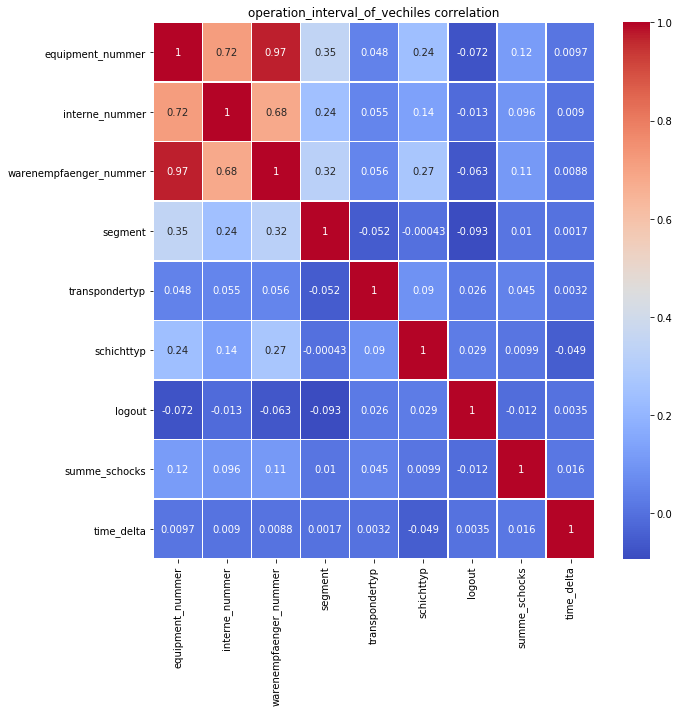

In [35]:
forklift.feature_correlation_plot(operation_interval_of_vechiles,'operation_interval_of_vechiles correlation')

feature engineering

In [16]:
#drop columns with no values
operation_interval_of_vechiles.drop(['warenempfaenger','land','ort','kostenstelle','einsatzort','freies_merkmal','fuehrerscheinklasse','equi_ok'],axis=1,inplace=True)


#encode the categorical values using Sklearn Labelcencoder package.
operation_interval_of_vechiles[['segment','transpondertyp','schichttyp','logout']]= \
operation_interval_of_vechiles[['segment','transpondertyp','schichttyp','logout']].apply(LabelEncoder().fit_transform)

#convert string to datetime
time_einsatzbeginn=pd.to_datetime(operation_interval_of_vechiles['einsatzbeginn'])
time_einsatzenden=pd.to_datetime(operation_interval_of_vechiles['einsatzende'])

#fetch duration of opeartion interval
time_delta=(time_einsatzenden-time_einsatzbeginn).astype('timedelta64[m]')

operation_interval_of_vechiles['time_delta']=time_delta
operation_interval_of_vechiles.drop(['einsatzbeginn','einsatzende'],axis=1,inplace=True)

#fill nulll values with 0
operation_interval_of_vechiles.fillna(0,inplace=True)
operation_interval_of_vechiles.head()

equipment_nummer  interne_nummer  warenempfaenger_nummer  segment  \
0                10            10.0                       1        0   
1               653           473.0                      19        5   
2               373           306.0                      10        4   
3                 5             5.0                       1        0   
4                24            22.0                       1        0   

   transpondertyp  schichttyp  logout  summe_schocks  time_delta  
0               0           5       0              0        28.0  
1               0           5       0              0         2.0  
2               0           5       3              0         2.0  
3               0           5       2              0        37.0  
4               0           5       2              0        17.0

operation_interval_of_vechiles : There are two possible predictive models from this data
1. We can estimate the total shock i.e summe_schocks: as a prediction for shocks we can caliber the forklifs.
2. We can estimate the type of logout, using this feature we can categorize forklifts logout behavior and work on that.

    The problem will be classified as regression problem as label to predict i.e is summe_schocks is continous in nature.
    We have used here Neural Network using Keras Api with an input layer, a hidden layer and an output layer.
    To validate our model, we have split data into train and validation set and have use MSE metrics.
    We have also used Early Stopping on validation set.

        
    Rseults:

            We can use model loss plot to check the efficiency of the model.

    Imporvements:

            We can try with more dense layers.
            Hypreparameter tuning can be done.

In [36]:
X_train, X_test, y_train, y_test=forklift.process_data("regressor",operation_interval_of_vechiles,'summe_schocks')

train data features and labels shape:  (129195, 8) (129195,) 
test data features and labels shape:   (43065, 8) (43065,)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 12)                108       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
Train on 103356 samples, validate on 25839 samples
Epoch 1/150
103356/103356 [==============================] - 3s 32us/step - loss: 7.2709 - mse: 7.2709 - mae: 0.4667 - val_loss: 7.3668 - val_mse: 7.3668 - val_mae: 0.5174
Epoch 2/150
103356/103356 [==============================] - 3s 30us/step - loss: 6.9751 - mse: 6.9751 - mae: 0.4922 - val_loss: 7.1605 - val_mse: 7.1605 - val_mae

Epoch 44/150
103356/103356 [==============================] - 3s 32us/step - loss: 4.3421 - mse: 4.3421 - mae: 0.3412 - val_loss: 4.4441 - val_mse: 4.4441 - val_mae: 0.3442
Epoch 45/150
103356/103356 [==============================] - 3s 30us/step - loss: 4.3755 - mse: 4.3755 - mae: 0.3559 - val_loss: 4.4817 - val_mse: 4.4817 - val_mae: 0.3380
Epoch 46/150
103356/103356 [==============================] - 3s 30us/step - loss: 4.3145 - mse: 4.3145 - mae: 0.3502 - val_loss: 4.4341 - val_mse: 4.4341 - val_mae: 0.3413
Epoch 47/150
103356/103356 [==============================] - 3s 30us/step - loss: 4.3495 - mse: 4.3495 - mae: 0.3578 - val_loss: 4.4636 - val_mse: 4.4636 - val_mae: 0.3661
Epoch 48/150
103356/103356 [==============================] - 3s 30us/step - loss: 4.4089 - mse: 4.4089 - mae: 0.3508 - val_loss: 4.3920 - val_mse: 4.3920 - val_mae: 0.3528
Epoch 49/150
103356/103356 [==============================] - 3s 30us/step - loss: 4.2991 - mse: 4.2991 - mae: 0.3475 - val_loss: 4.447

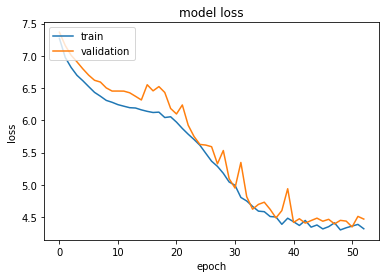

In [35]:
model_nn=forklift.baseline_model(X_train,y_train,X_test,y_test)

        The problem will be classified as multiclass classification problem.
        There are 4 types of logout in total in the given dataset.
        We can use Random Forest algorithm to build our predictor.
        To validate our model, we have split data into train and test using Sklearn train_test_split.
        Since there are 4 different classes, so we have used stratify split to have same ratio of class in test & test.
        We have used class_weight as "balanced_subsample" in RF model to counter the class imbalancement.
        To validate our model we have used Sklearn classification_report, which gives per class classification.
        
        Rseults:

                From classification report, we can observe that model works  well for those classes which has more records.
                However, model also able to pick minority classes. 

        Imporvements:

                We can cross validation to hypter tune the parameters.
                To counter class imbalancement we can use synthetic over sampler such as SMOTE.
                We can also combine minority classes with very less records and do the classification.
                We can create one vs rest model and with that we can create ensembles.

In [17]:
X_train, X_test, y_train, y_test= forklift.process_data("classifier",operation_interval_of_vechiles,'logout')
#create the model
model = RandomForestClassifier(n_estimators=1200, max_depth=20,class_weight="balanced_subsample")
#train and evaluate the model
score = forklift.evaluate_model(X_train,y_train,model,X_test,y_test,'classifier','operation_interval_of_vechiles_logout')

              precision    recall  f1-score   support

           0       0.69      0.60      0.64     14705
           1       0.20      0.35      0.26      2402
           2       0.80      0.80      0.80     25646
           3       0.55      0.84      0.67       312

    accuracy                           0.71     43065
   macro avg       0.56      0.65      0.59     43065
weighted avg       0.72      0.71      0.71     43065



# number_intencity_shocks

In [18]:
#schocklevel classification
number_intencity_shocks= forklift.read_data("./datasets/5_schocks_gestapelt_land.csv",sep=(";"))
print(number_intencity_shocks.shape)
print(number_intencity_shocks.schocklevel.value_counts())
number_intencity_shocks.drop(['warenempfaenger','land','ort','einsatzort','freies_merkmal','kostenstelle','fuehrerscheinklasse','strasse','equi_ok'],axis=1,inplace=True)

number_intencity_shocks.head()

shape of data: (46271, 24) 

columns in data: Index(['land', 'ort', 'equipment_nummer', 'interne_nummer', 'segment', 'typ',
       'warenempfaenger_nummer', 'warenempfaenger', 'strasse', 'plz',
       'mitarbeitername', 'zeitpunkt', 'schichttyp', 'schocklevel',
       'intensitaet', 'fahrzeugverhalten', 'freischaltung_durch',
       'einsatzbeginn', 'einsatzende', 'equi_ok', 'kostenstelle', 'einsatzort',
       'fuehrerscheinklasse', 'freies_merkmal'],
      dtype='object') 

show null values in data: 
land                      46271
ort                       46271
equipment_nummer              0
interne_nummer             6647
segment                       0
typ                           0
warenempfaenger_nummer        0
warenempfaenger               0
strasse                       0
plz                           0
mitarbeitername               0
zeitpunkt                     0
schichttyp                    0
schocklevel                   0
intensitaet                   0
fahrzeugverh

equipment_nummer  interne_nummer             segment      typ  \
0               803             NaN  Niederhubwagen-KMS  ECE 225   
1               803             NaN  Niederhubwagen-KMS  ECE 225   
2               803             NaN  Niederhubwagen-KMS  ECE 225   
3               803             NaN  Niederhubwagen-KMS  ECE 225   
4               803             NaN  Niederhubwagen-KMS  ECE 225   

   warenempfaenger_nummer   plz mitarbeitername            zeitpunkt  \
0                      22  1899         Default  31.08.2020 23:40:11   
1                      22  1899         Default  31.08.2020 23:40:21   
2                      22  1899         Default  31.08.2020 23:40:37   
3                      22  1899         Default  31.08.2020 23:40:47   
4                      22  1899         Default  31.08.2020 23:41:35   

        schichttyp  schocklevel    intensitaet  fahrzeugverhalten  \
0  Nicht definiert            1  2.4 g / 2.1 g                  1   
1  Nicht definiert            1  2.2 g / 1.9 g                  1   
2  Nicht definiert            1  3.4 g / 2.8 g                  1   
3  Nicht definiert            1  3.5 g / 2.6 g                  1   
4  Nicht definiert            1  2.3 g / 1.8 g                  1   

  freischaltung_durch        einsatzbeginn          einsatzende  
0                  -0  31.08.2020 23:37:09  31.08.2020 23:58:17  
1                  -0  31.08.2020 23:37:09  31.08.2020 23:58:17  
2                  -0  31.08.2020 23:37:09  31.08.2020 23:58:17  
3                  -0  31.08.2020 23:37:09  31.08.2020 23:58:17  
4                  -0  31.08.2020 23:37:09  31.08.2020 23:58:17

In [40]:
forklift.label_distribution(number_intencity_shocks, 'segment',' number_intencity_shocks segment distribution')
forklift.label_distribution(number_intencity_shocks, 'typ','number_intencity_shocks typ distribution')
forklift.label_distribution(number_intencity_shocks, 'schocklevel',' number_intencity_shocks schocklevel distribution')
forklift.label_distribution(number_intencity_shocks, 'mitarbeitername','number_intencity_shocks mitarbeitername distribution')
forklift.label_distribution(number_intencity_shocks, 'fahrzeugverhalten','number_intencity_shocks fahrzeugverhalten distribution')

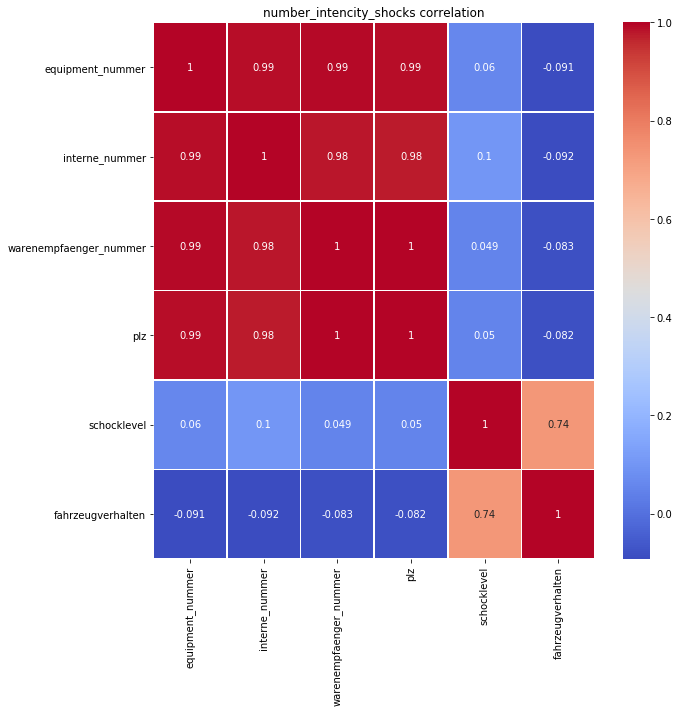

In [41]:
forklift.feature_correlation_plot(number_intencity_shocks,'number_intencity_shocks correlation')

Feature Engineering

In [19]:
#convert string to datetime
time_einsatzbeginn=pd.to_datetime(number_intencity_shocks['einsatzbeginn'])
time_einsatzenden=pd.to_datetime(number_intencity_shocks['einsatzende'])

#fetch duration of opeartion interval
time_delta=(time_einsatzenden-time_einsatzbeginn).astype('timedelta64[m]')
number_intencity_shocks['time_delta']=time_delta
number_intencity_shocks.drop(['einsatzbeginn','einsatzende','zeitpunkt'],axis=1,inplace=True)

#encode the categorical values using Sklearn Labelcencoder package.
number_intencity_shocks[['segment','typ','schichttyp','mitarbeitername','plz']]= \
number_intencity_shocks[['segment','typ','schichttyp','mitarbeitername','plz']].apply(LabelEncoder().fit_transform)

#convert string to numeric
number_intencity_shocks['freischaltung_durch']=number_intencity_shocks['freischaltung_durch'].apply(lambda x: 0 if x=="-0" else 1)

#calculate intensity ratio
number_intencity_shocks['intensitaet']= number_intencity_shocks['intensitaet'].apply(lambda x: float(x.split(" ")[0])/float(x.split(" ")[3]))

#fill nulll values with 0
number_intencity_shocks.fillna(0,inplace=True)

number_intencity_shocks.head()

equipment_nummer  interne_nummer  segment  typ  warenempfaenger_nummer  \
0               803             0.0        5    3                      22   
1               803             0.0        5    3                      22   
2               803             0.0        5    3                      22   
3               803             0.0        5    3                      22   
4               803             0.0        5    3                      22   

   plz  mitarbeitername  schichttyp  schocklevel  intensitaet  \
0   16                1           4            1     1.142857   
1   16                1           4            1     1.157895   
2   16                1           4            1     1.214286   
3   16                1           4            1     1.346154   
4   16                1           4            1     1.277778   

   fahrzeugverhalten  freischaltung_durch  time_delta  
0                  1                    0        21.0  
1                  1                    0        21.0  
2                  1                    0        21.0  
3                  1                    0        21.0  
4                  1                    0        21.0

number_intencity_shocks : we can use this data to predict the level of shock or intensity of shock, we can use this information to optimse forklifts.
        
        The problem will be classified as multiclass classification problem.
        There are 3 types of schocklevel in total in the given dataset.
        We can use Random Forest algorithm to build our predictor.
        To validate our model, we have split data into train and test using Sklearn train_test_split.
        Since there are schocklevel different classes, so we have used stratify split to have same ratio of 
        class in test & test.
        We have used class_weight as "balanced_subsample" in RF model to counter the class imbalancement.
        To validate our model we have used Sklearn classification_report, which gives per class classification.
        
Rseults:

        From classification report, we can observe that model works well in predicting multiple classes.
        
Imporvements:

        We can do cross validation to hypter tune the parameters.
        To counter class imbalancement we can use synthetic over sampler such as SMOTE.
        We can also combine minority classes with very less records and do the classification.

In [20]:
X_train, X_test, y_train, y_test=forklift.process_data("classifier",number_intencity_shocks,'schocklevel')
#create the model
model = RandomForestClassifier(n_estimators=300, max_depth=10,class_weight="balanced_subsample")

#train and evaluate the model
score = forklift.evaluate_model(X_train,y_train,model,X_test,y_test,'classifier','number_intencity_shocks')

              precision    recall  f1-score   support

           1       0.88      0.64      0.74      6226
           2       0.47      0.78      0.59      2585
           3       0.99      0.99      0.99      2757

    accuracy                           0.76     11568
   macro avg       0.78      0.81      0.77     11568
weighted avg       0.82      0.76      0.77     11568



# opeartions_hrs_reading_dates

In [4]:
opeartions_hrs_reading_dates=forklift.read_data("./datasets/11_messpunkte_land.csv",sep=(";"))
opeartions_hrs_reading_dates.head()

shape of data: (13534, 17) 

columns in data: Index(['warenempfaenger', 'warenempfaenger_nummer', 'land', 'strasse', 'plz',
       'ort', 'interne_nummer', 'equipment_nummer', 'segment', 'typ',
       'hersteller', 'baujahr', 'zugangsmodul', 'zugangsmodul1', 'messdatum',
       'messuhrzeit', 'letzter_betriebsstundenstand'],
      dtype='object') 

show null values in data: 
warenempfaenger                     0
warenempfaenger_nummer              0
land                            13534
strasse                             0
plz                                 0
ort                             13534
interne_nummer                   1878
equipment_nummer                    0
segment                             0
typ                                 0
hersteller                          0
baujahr                             0
zugangsmodul                        0
zugangsmodul1                       0
messdatum                           0
messuhrzeit                         0
letzter_betrie

warenempfaenger  warenempfaenger_nummer  land strasse   plz  ort  \
0             ABC                      15   NaN  Weg 14  1233  NaN   
1             ABC                      19   NaN  Weg 18  1566  NaN   
2             ABC                      15   NaN  Weg 14  1233  NaN   
3             ABC                       5   NaN   Weg 5   567  NaN   
4             ABC                      22   NaN  Weg 21  1899  NaN   

   interne_nummer  equipment_nummer             segment      typ  \
0           396.0               504      Niederhubwagen  ERE 225   
1           476.0               656  Niederhubwagen-KMS  ECE 225   
2           414.0               543    Hochhubwagen-KMS  EKS 312   
3             NaN               201      Niederhubwagen  ERE 225   
4           579.0               791    Schubmaststapler  ETV 216   

     hersteller     baujahr zugangsmodul  zugangsmodul1   messdatum  \
0  Jungheinrich  01/03/2015            X              1  31/08/2020   
1  Jungheinrich  01/06/2017            X              1  31/08/2020   
2  Jungheinrich  01/05/2018            X              1  31/08/2020   
3  Jungheinrich  01/01/2012            X              1  31/08/2020   
4  Jungheinrich  01/08/2012            X              1  31/08/2020   

  messuhrzeit  letzter_betriebsstundenstand  
0       10:20                          3352  
1       13:00                          3506  
2       12:00                          2106  
3       05:43                          3576  
4       13:02                          9053

Insights from data

In [45]:
forklift.label_distribution(opeartions_hrs_reading_dates, 'segment',' opeartions_hrs_reading_dates segment distribution')
forklift.label_distribution(opeartions_hrs_reading_dates, 'warenempfaenger_nummer','opeartions_hrs_reading_dates warenempfaenger_nummer distribution')
forklift.label_distribution(opeartions_hrs_reading_dates, 'hersteller',' opeartions_hrs_reading_dates hersteller distribution')

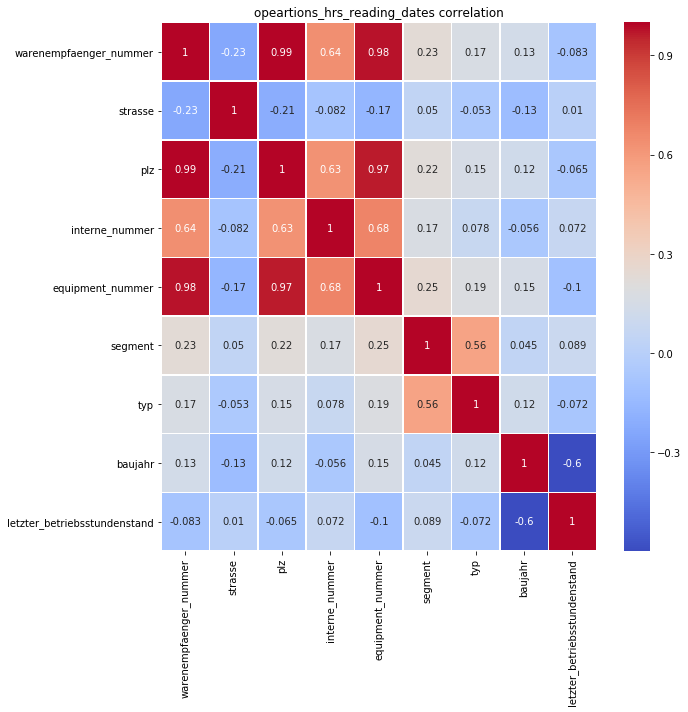

In [7]:
forklift.feature_correlation_plot(opeartions_hrs_reading_dates,'opeartions_hrs_reading_dates correlation')

Feature Engineering

In [5]:
opeartions_hrs_reading_dates.drop(['warenempfaenger','land','ort','zugangsmodul1','zugangsmodul','hersteller','messdatum','messuhrzeit'],axis=1,inplace=True)
opeartions_hrs_reading_dates['baujahr'] = pd.DatetimeIndex(opeartions_hrs_reading_dates['baujahr']).year
#encode the categorical values using Sklearn Labelcencoder package.
opeartions_hrs_reading_dates[['segment','typ','strasse','plz']]= \
opeartions_hrs_reading_dates[['segment','typ','strasse','plz']].apply(LabelEncoder().fit_transform)
print(opeartions_hrs_reading_dates.shape)
#fill nulll values with 0
opeartions_hrs_reading_dates.fillna(0,inplace=True)
opeartions_hrs_reading_dates.head()

(13534, 9)


warenempfaenger_nummer  strasse  plz  interne_nummer  equipment_nummer  \
0                      15        5   10           396.0               504   
1                      19        9   13           476.0               656   
2                      15        5   10           414.0               543   
3                       5       18    4             0.0               201   
4                      22       13   16           579.0               791   

   segment  typ  baujahr  letzter_betriebsstundenstand  
0        4   27     2015                          3352  
1        5    3     2017                          3506  
2        2   21     2018                          2106  
3        4   27     2012                          3576  
4        7   31     2012                          9053

opeartions_hrs_reading_dates: using this data we can predict opearting hour level.

        The problem will be classified as regression problem as label to predict is continous in nature.
        we  use Random Forest Regressor as our predictor.
        To validate our model, we have split data into train and test using Sklearn train_test_split.
        To validate our model we have use SKlearn metrics r2_Score i.e R^2 (coefficient of determination) 
         regression score function.
        
Rseults:

        Since our R^2 (coefficient of determination) value is 0.90, we can conclude that our predictor is working well.
        
Imporvements:

        We can do cross validation to hypter tune the parameters.
        We can also compare our model with  other algorithm like Nueral Networks if we have sufficiently large data.

In [6]:
X_train, X_test, y_train, y_test = forklift.process_data("regressor",opeartions_hrs_reading_dates,"letzter_betriebsstundenstand")

#create the model
regr = RandomForestRegressor(max_depth=9, random_state=0,n_estimators=800)
r2_score=forklift.evaluate_model(X_train,y_train,regr,X_test,y_test,'regressor','letzter_betriebsstundenstand_model')
print("r2_score",r2_score)

train data features and labels shape:  (10150, 8) (10150,) 
test data features and labels shape:   (3384, 8) (3384,)
r2_score 0.8932188817814902
